# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets # для удобства работы с данными

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.5 MB/s eta 0:00:00


In [1]:
import datasets # при работе локально

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset

# https://www.nltk.org/api/nltk.tokenize.html?highlight=tokenize#module-nltk.tokenize
# https://www.nltk.org/api/nltk.tokenize.word_tokenize.html?highlight=word_tokenize#nltk.tokenize.word_tokenize
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
torch.cuda.is_available()

True

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Found cached dataset ag_news (C:/Users/pzele/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Посмотрю на датасет

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Посмотрю один текст и к нему лейбл

In [7]:
dataset['train']['text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [8]:
dataset['train']['label'][0]

2

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

### Подсчитаем частоту вхождения слов, чтобы составить словарь

In [7]:
# подсчет частоты вхождений слов
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/120000 [00:00<?, ?it/s]

In [10]:
# длина словаря
len(words)

102166

In [11]:
# 10 самых частых исп слов из текстов
words.most_common(10)

[('the', 203527),
 ('to', 119026),
 ('a', 107550),
 ('of', 97908),
 ('in', 95430),
 ('and', 68852),
 ('on', 56507),
 ('for', 50168),
 ('39s', 31218),
 ('that', 27741)]

### Составим словарь

1. туда попадут спец токены
  - unk - неизвестный токен
  - bos - начало предл
  - eos - конец предл
  - pad - спец токен для объедин посл разн длин в один батч

2. В словарь будем добавлять только те слова, кот встретились больше 25 (экспериментальное число, можно варьировать) раз в нашем корпусе слов , words - то что считали выше

In [8]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 11842


### Мапаем словарь 

Берем слооварь vocab (set), итерируемся по нему и пронумеровываем каждый токен и кладем в словарь. Получаем 2 словаря. Один будет предстовалять собой token : index, другой index : token

In [9]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Класс для Датасета

In [10]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences # принимает предложение
        # для удобства индексы спец токенов из словаря
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
      # преобраз предл как это былоо выше когда считали частоту вхожд слов
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # в начало предл ставим спец токен начала предложения, его индекс
        tokenized_sentence = [self.bos_id]
        # из преобр предл достаем токены и добавляем в предложение, при этом
        # проверяем есть ли это слово в словаре, если есть то добавляем, если
        # нет то добавляем спец индекс unk, его индекс из словаря
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        # в самом конце добавляем спец токен конца предложения
        tokenized_sentence += [self.eos_id]
        # результат работы фции будет словарь
        train_sample = {
            "text": tokenized_sentence, # индексы преобл предложения со спец токенами
            "label": self.data[idx]['label'] # лейбл этого предложения (0 или 1)
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
# class WordDataset:
#     def __init__(self, sentences):
#         self.data = sentences
#         self.unk_id = word2ind['<unk>']
#         self.bos_id = word2ind['<bos>']
#         self.eos_id = word2ind['<eos>']
#         self.pad_id = word2ind['<pad>']

#     def __getitem__(self, idx: int) -> List[int]:
#         processed_text = self.data[idx]['text'].lower().translate(
#             str.maketrans('', '', string.punctuation))
#         tokenized_sentence = [self.bos_id]
#         tokenized_sentence += [
#             word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
#             ] 
#         tokenized_sentence += [self.eos_id]

#         train_sample = {
#             "text": tokenized_sentence,
#             "label": self.data[idx]['label']
#         }

#         return train_sample

#     def __len__(self) -> int:
#         return len(self.data)

### Функция приводящая предл к одной длине

In [11]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    
    # считаем все длины предл в поданном батче и кладем в список
    seq_lens = [len(x['text']) for x in input_batch]
    
    # опред макс длину предл: либо 256 как задано в арг фции, либо размер
    # самого длинн текста из батча
    max_seq_len = min(max(seq_lens), max_len)

    # делаем новый батч
    new_batch = []
    
    # проходимся по предл из батча
    for sequence in input_batch:
      
      # обрезаем предл по макс длине найденной выше
        sequence['text'] = sequence['text'][:max_seq_len]

      # в диапазоне от max_len до размера самого длинн предл из батча
        for _ in range(max_seq_len - len(sequence['text'])):
          
          # добавляем паддинги, индексы спец токена pad_id
            sequence['text'].append(pad_id)
          # получаем индексы bos token1, token2,..eos, pad, pad...pad

        new_batch.append(sequence['text'])
    
    # преобр индексы предл в Тензор LongTensor torch и кладем на куду
    sequences = torch.LongTensor(new_batch).to(device)
    # преобр лейблы в Тензор LongTensor torch и кладем на куду
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    # вид нового батча
    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
# def collate_fn_with_padding(
#     input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
#     seq_lens = [len(x['text']) for x in input_batch]
#     max_seq_len = min(max(seq_lens), max_len)

#     new_batch = []
#     for sequence in input_batch:
#         sequence['text'] = sequence['text'][:max_seq_len]
#         for _ in range(max_seq_len - len(sequence['text'])):
#             sequence['text'].append(pad_id)

#         new_batch.append(sequence['text'])
    
#     sequences = torch.LongTensor(new_batch).to(device)
#     labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

#     new_batch = {
#         'input_ids': sequences,
#         'label': labels
#     }

#     return new_batch

### Создаем датасеты и даталоадеры

In [12]:
# train dataset
train_dataset = WordDataset(dataset['train'])

# eval dataset
np.random.seed(42)
# рандомно возьсем 5000 тыс индексов из тестового датасета
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

# Размер батча
batch_size = 32

# train dataloader
# заметим, что указываем collate_fn_with_padding для привед к одной длине с паддингами
# с shuffle
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# eval dataloader
eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [13]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

# Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Запуск базовой модели с семинара на новом датасете

### Архитектура модели

In [20]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [21]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [23]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [25]:
losses_type

{'max': [0.4022612098455429,
  0.27870417011231186,
  0.24807602316836516,
  0.22253926432629426,
  0.20488973529810706],
 'mean': [0.4403167425304651,
  0.26179769431402283,
  0.21535860877012214,
  0.18426884434744717,
  0.16022405575178564]}

In [26]:
acc_type

{'max': [0.2393999993801117,
  0.8819999694824219,
  0.8889999985694885,
  0.8871999979019165,
  0.8991999626159668,
  0.8985999822616577,
  0.8991999626159668,
  0.9005999565124512,
  0.8949999809265137,
  0.8941999673843384],
 'mean': [0.2451999932527542,
  0.8736000061035156,
  0.8935999870300293,
  0.9061999917030334,
  0.9021999835968018,
  0.9047999978065491,
  0.9053999781608582,
  0.9027999639511108,
  0.9035999774932861,
  0.9049999713897705]}

In [24]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

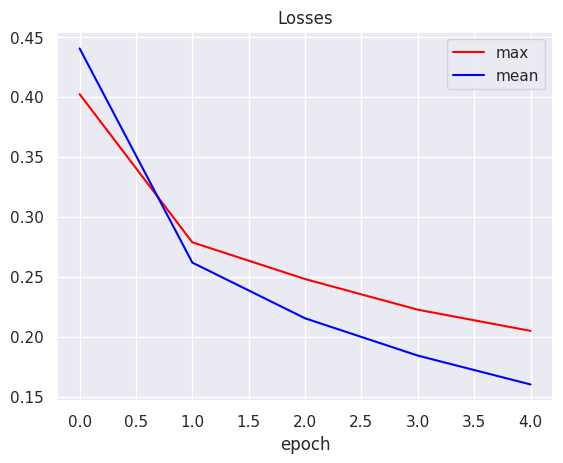

In [27]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.06
Лучшая accuracy для подхода mean: 90.62


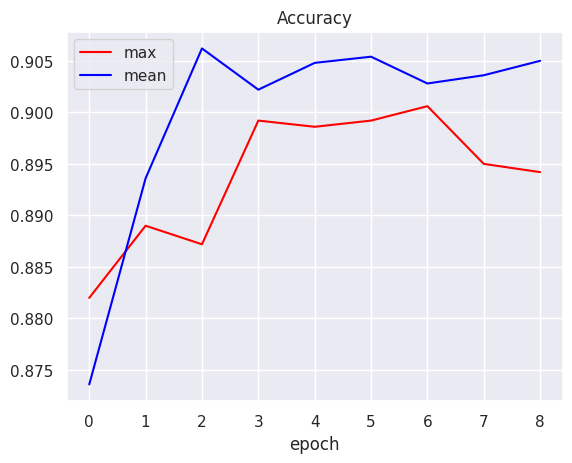

In [28]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Как видно из результатов семинара и текущих результатов, с ростом количества эпох качество accuracy лучше при аггрегации типа mean. Поэтому в дальнейших экспериментах для экономии времени, я буду ипользовать только один вид аггрегации mean.

2. Лучшая accuracy для подхода mean: 90.62 - это будет наш baseline

## Увеличение количества рекуррентных слоев модели

### Архитектура модели

In [32]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        # внесу тут изменение добавив количество слоев RNN=5
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=5,  batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [33]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [34]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

# как я писал выше, mean показывает себя лучше, поэтому оставлю только его
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [35]:
losses_type

{'mean': [0.5597010211428006,
  0.33614244741698107,
  0.2928291707187891,
  0.26863091956079005,
  0.24554085717300575]}

In [36]:
acc_type

{'mean': [0.2581999897956848,
  0.8247999548912048,
  0.871399998664856,
  0.8809999823570251,
  0.8935999870300293,
  0.8894000053405762,
  0.8885999917984009,
  0.8967999815940857,
  0.8999999761581421,
  0.896399974822998]}

In [37]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'RNN_5layers'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

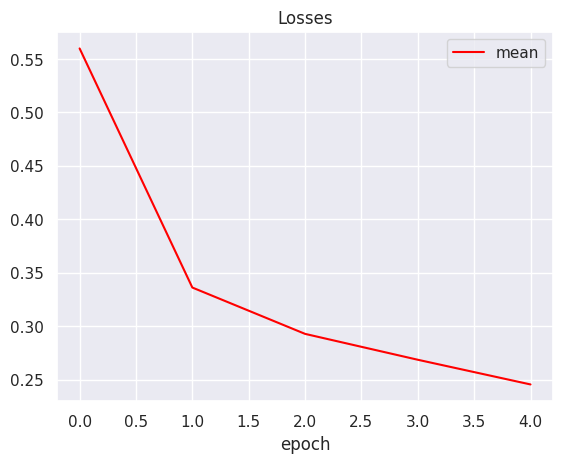

In [38]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.00


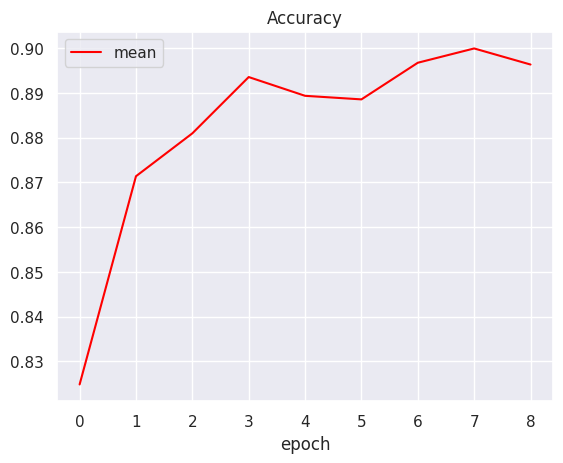

In [39]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 90.00

2. Прироста в качестве это не дало, даже чуть хуже стало, поэтому буду пробовать другие методы

## Конкатенация аггрегированных hidden states + final hidden state

### Архитектура модели

In [76]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(2*hidden_dim, 2*hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(2*hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

        # размер скрытых состояний
        self.hidden_dim = hidden_dim

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        # h_n = [количество слоев, batch size, hidden dim] - последние hidden state со всех слоев
        output, h_n = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]
      
        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        # конкатенация аггрегированных hidden states с последнего слоя с 
        # hidden state последнего токена
        
        # reshape h_n to [batch size, hidden state]
        h_n = torch.reshape(h_n,(h_n.shape[1], self.hidden_dim))
        
        # concat
        output = torch.cat((output,h_n),1)
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [77]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [78]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

# оставлю только mean
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [79]:
losses_type

{'mean': [0.4632116178204616,
  0.28382072219252585,
  0.2409922031181554,
  0.2136543518786629,
  0.19550085625809926]}

In [80]:
acc_type

{'mean': [0.2401999980211258,
  0.8452000021934509,
  0.886199951171875,
  0.8921999931335449,
  0.8944000005722046,
  0.9019999504089355,
  0.9031999707221985,
  0.8912000060081482,
  0.9023999571800232,
  0.9027999639511108]}

In [81]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'RNN+concat'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

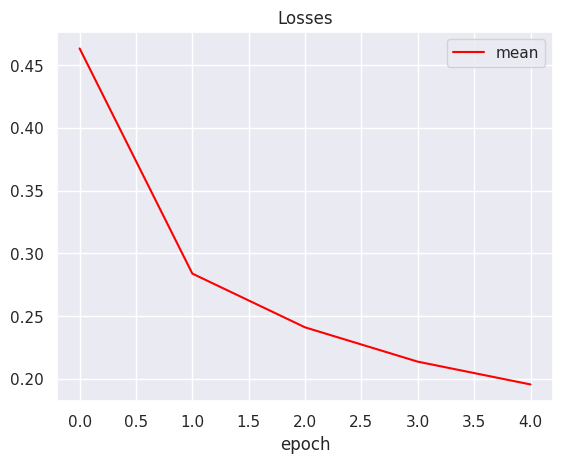

In [82]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.32


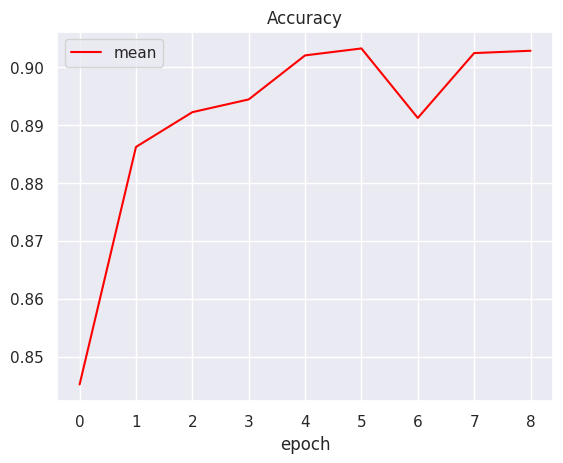

In [83]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 90.32

2. Уже результаты стали лучше, но все равно еще не перебиваем baseline


## GRU

### Архитектура модели

In [84]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель GRU от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

        # размер скрытых состояний
        self.hidden_dim = hidden_dim

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        # h_n = [количество слоев, batch size, hidden dim] - последние hidden state со всех слоев
        output, h_n = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]
      
        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [85]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [86]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

# оставлю только mean
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [87]:
losses_type

{'mean': [0.3659197796702385,
  0.20869943282306194,
  0.14482088113787273,
  0.09722721595515807,
  0.07057508856879237]}

In [88]:
acc_type

{'mean': [0.24639999866485596,
  0.8923999667167664,
  0.8998000025749207,
  0.9049999713897705,
  0.9081999659538269,
  0.9075999855995178,
  0.9131999611854553,
  0.9071999788284302,
  0.9063999652862549,
  0.9034000039100647]}

In [89]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'GRU'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

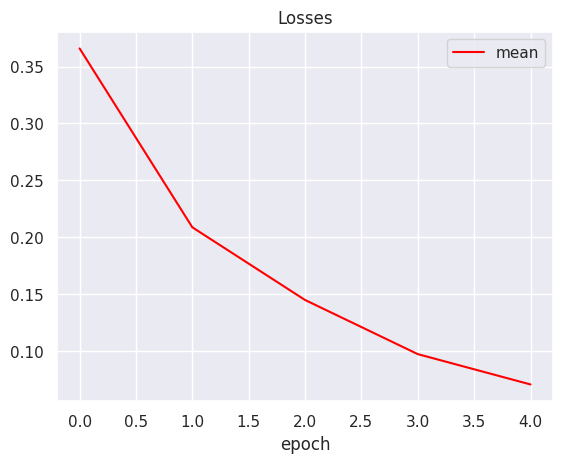

In [90]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.32


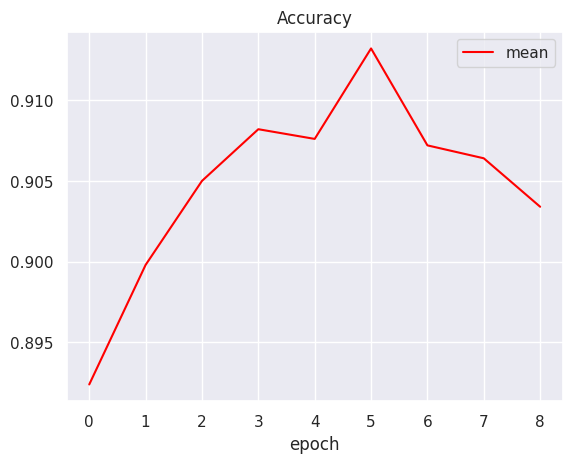

In [91]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 91.32

2. GRU лучше работает, но с 3й эпохи accuracy стал падать. Не понятно почему


## Запуск базовой модели с семинара с другим словарем, counter_threshold = 15

### Составим словарь

У нового словаря попробую поставить counter_threshold =15

In [106]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 15

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 15764


In [107]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [108]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [116]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [117]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [118]:
losses_type

{'mean': [0.44374908190170925,
  0.2573440995514393,
  0.2079469569839537,
  0.17397106778000793,
  0.14903411345363904]}

In [119]:
acc_type

{'mean': [0.2595999836921692,
  0.8511999845504761,
  0.8899999856948853,
  0.9021999835968018,
  0.9041999578475952,
  0.9016000032424927,
  0.9017999768257141,
  0.9019999504089355,
  0.9120000004768372,
  0.9073999524116516]}

In [120]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_15'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

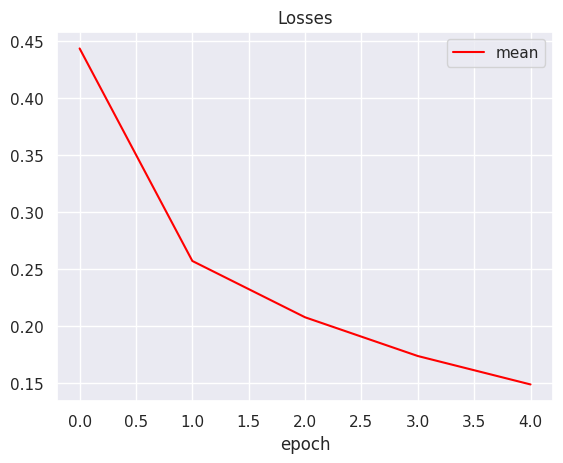

In [121]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.20


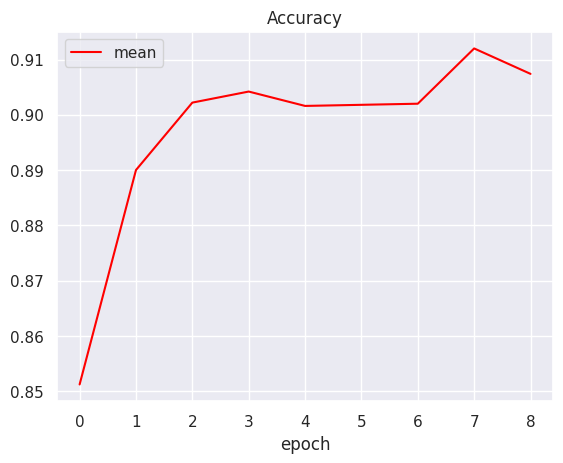

In [122]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 91.20

2. Сходу виден результат, всего лишь наша базовая модель из семинара, только со словарем с большим количеством токенов. До этого только GRU показал резулььтат лучший, но accuracy там падало с 3й эпохи.

Я думаю можно попробовать еще больше выжать увеличив словарь

## Запуск базовой модели с семинара с другим словарем, counter_threshold = 5

### Составим словарь

У нового словаря попробую поставить counter_threshold =5

In [123]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 5

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 27694


In [124]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [125]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [126]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [127]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [128]:
losses_type

{'mean': [0.4381427157630523,
  0.24520404342263938,
  0.1919553076316913,
  0.15446893607800205,
  0.12785427912554392]}

In [129]:
acc_type

{'mean': [0.241799995303154,
  0.8669999837875366,
  0.8995999693870544,
  0.8859999775886536,
  0.8998000025749207,
  0.9081999659538269,
  0.9097999930381775,
  0.9085999727249146,
  0.9049999713897705,
  0.9089999794960022]}

In [130]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_5'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

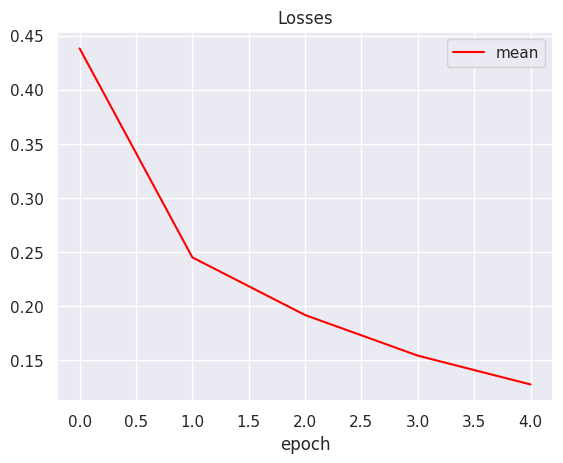

In [131]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.98


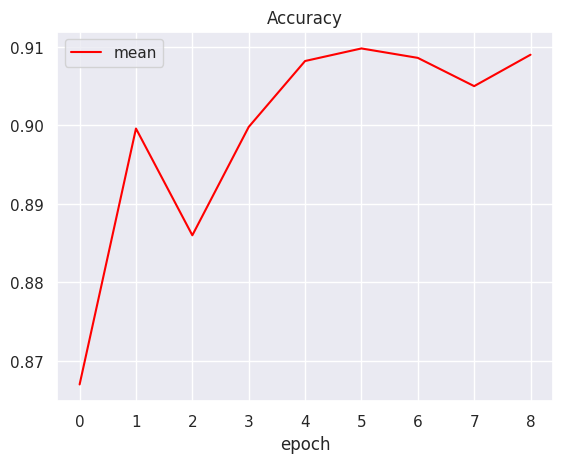

In [132]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 90.98

2. Результат немного ухудшился. Возьму в след раз побольше значение для создания словаря

## Запуск базовой модели с семинара с другим словарем, counter_threshold = 10

### Составим словарь

У нового словаря попробую поставить counter_threshold =10

In [133]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 10

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 19562


In [134]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [135]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [136]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [137]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [138]:
losses_type

{'mean': [0.44121070142487684,
  0.2539832459618648,
  0.20215052296519279,
  0.16685292040929198,
  0.14032428201908867]}

In [139]:
acc_type

{'mean': [0.2425999939441681,
  0.8763999938964844,
  0.8953999876976013,
  0.8995999693870544,
  0.9055999517440796,
  0.9043999910354614,
  0.9021999835968018,
  0.9067999720573425,
  0.911799967288971,
  0.9067999720573425]}

In [140]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_10'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

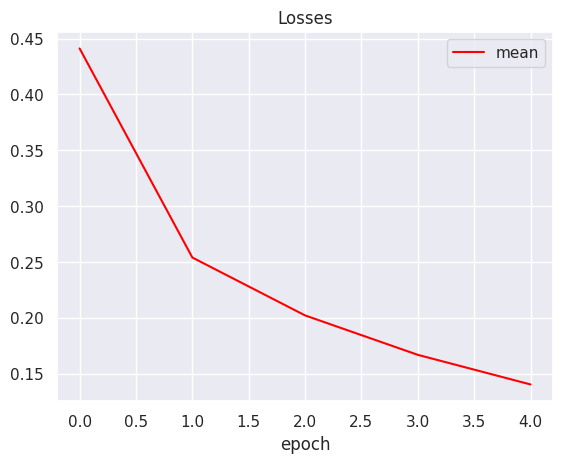

In [141]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.18


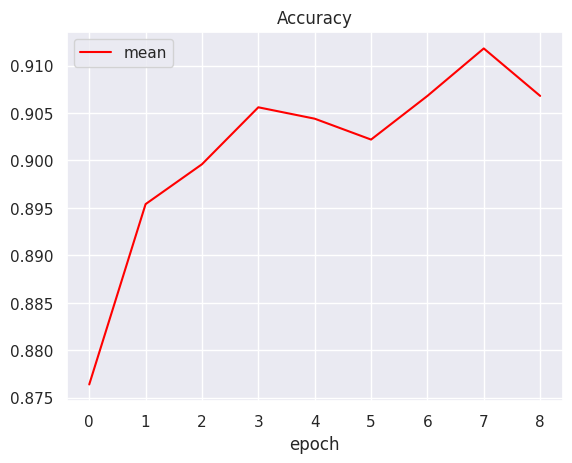

In [142]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 91.18

2. Результат практически как и при counter_threshold = 15. Попробую последнюю попытку для counter_threshold = 20

## Запуск базовой модели с семинара с другим словарем, counter_threshold = 20

### Составим словарь

У нового словаря попробую поставить counter_threshold =20

In [143]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 20

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 13403


In [144]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [145]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [146]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [147]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [148]:
losses_type

{'mean': [0.4354928648600976,
  0.2553960954690973,
  0.20913032971173526,
  0.17884365629926324,
  0.15504189843138058]}

In [149]:
acc_type

{'mean': [0.25119999051094055,
  0.8779999613761902,
  0.8871999979019165,
  0.8973999619483948,
  0.8931999802589417,
  0.9023999571800232,
  0.8941999673843384,
  0.9039999842643738,
  0.9071999788284302,
  0.902999997138977]}

In [150]:
pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_20'+'.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

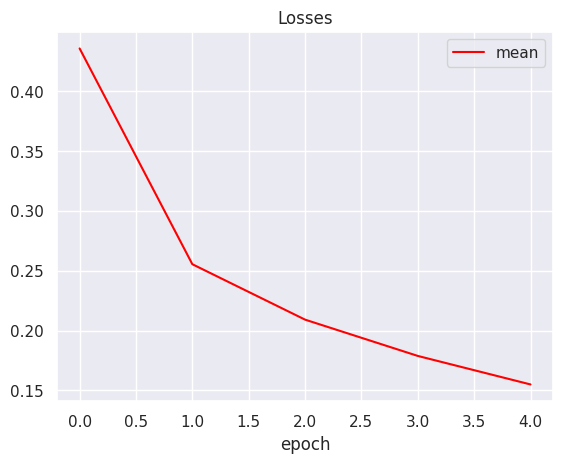

In [151]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.72


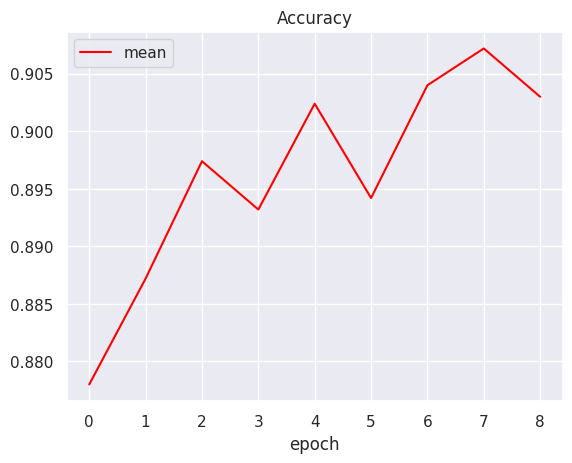

In [152]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 90.72

2. Результат эталонного counter_threshold = 15 которое я с первого раза угадал. Можно попробовать поперебирать между 10-15, но я этого не буду делать а перейду к следующим улучшениям

## Bidirectionl RNN с другим словарем, counter_threshold = 15

### Составим словарь

У нового словаря попробую поставить counter_threshold =15

In [14]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 15

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 15764


In [15]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [17]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, bidirectional = True)
        
        #  лин слой
        self.linear = nn.Linear(2*hidden_dim, 2*hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(2*hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [19]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [20]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [21]:
losses_type

{'mean': [0.4408675573199987,
  0.25648473631242913,
  0.2091501688234508,
  0.17809490195512773,
  0.15642430282744268]}

In [22]:
acc_type

{'mean': [0.30660000443458557,
  0.8757999539375305,
  0.8999999761581421,
  0.9047999978065491,
  0.9097999930381775,
  0.9131999611854553,
  0.911799967288971,
  0.914199948310852,
  0.914199948310852,
  0.9089999794960022]}

In [23]:
# pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_15'+'.pkl'
pkl_name = 'C:/Users/pzele/Downloads/' + 'BiRNN_vocab_15' + '.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

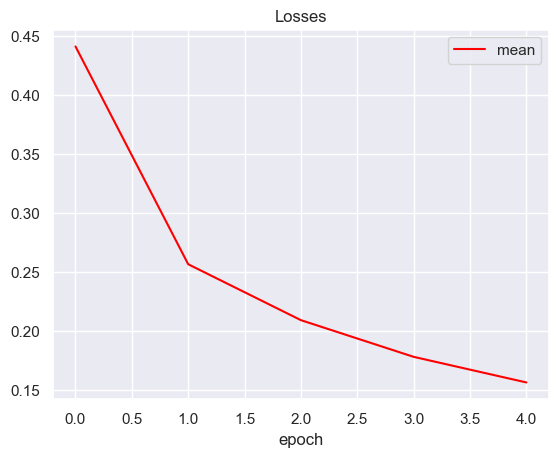

In [25]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.42


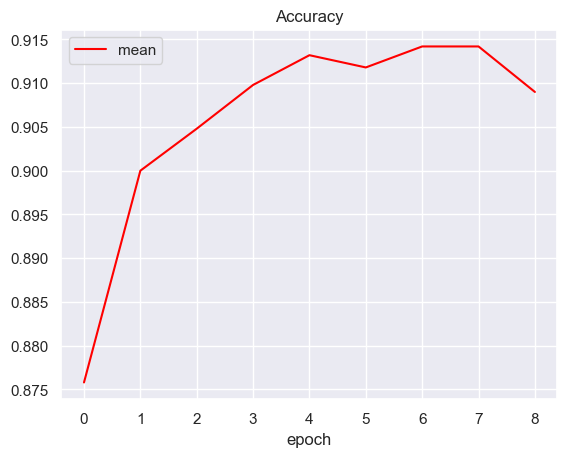

In [26]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 91.42

2. Результат даже лучше чем для GRU самого простого. Попробую далее несколько слоев еще сделать

## Bidirectionl RNN + 3 Доп слоя, с другим словарем, counter_threshold = 15


### Составим словарь

У нового словаря попробую поставить counter_threshold =15

In [27]:
# создание словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 15

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 15764


In [28]:
# создадим 2 словаря {token : index}, {index : token}
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Архитектура модели

In [29]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers =3, batch_first=True, bidirectional = True)
        
        #  лин слой
        self.linear = nn.Linear(2*hidden_dim, 2*hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(2*hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # output [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

### Train loop

In [30]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [31]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [32]:
losses_type

{'mean': [0.4513906557838122,
  0.27222853132883706,
  0.2229353983265658,
  0.1921954377391686,
  0.16933737388538816]}

In [33]:
acc_type

{'mean': [0.2667999863624573,
  0.8601999878883362,
  0.8883999586105347,
  0.8959999680519104,
  0.8985999822616577,
  0.8921999931335449,
  0.8953999876976013,
  0.9081999659538269,
  0.9059999585151672,
  0.9019999504089355]}

In [34]:
# pkl_name = '/content/drive/MyDrive/Colab Notebooks/'+'baselline_vocab_15'+'.pkl'
pkl_name = 'C:/Users/pzele/Downloads/' + 'BiRNN_3Layers_vocab_15' + '.pkl'
with open(pkl_name, "wb") as f:
    pickle.dump(losses_type, f)
    pickle.dump(acc_type, f)

'''
with open(pkl_name, "rb") as f:
    losses_type = pickle.load(f)
    acc_type = pickle.load(f)
'''

'\nwith open(pkl_name, "rb") as f:\n    losses_type = pickle.load(f)\n    acc_type = pickle.load(f)\n'

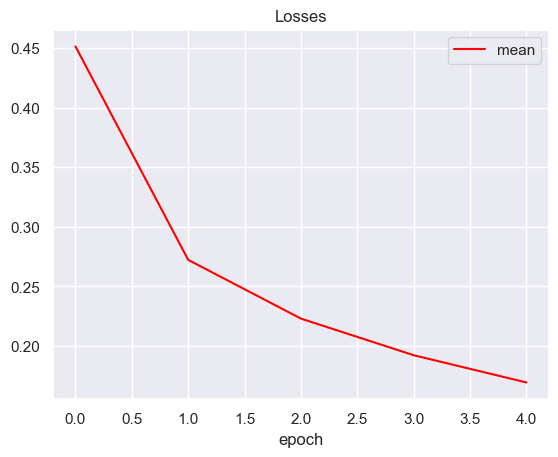

In [35]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.82


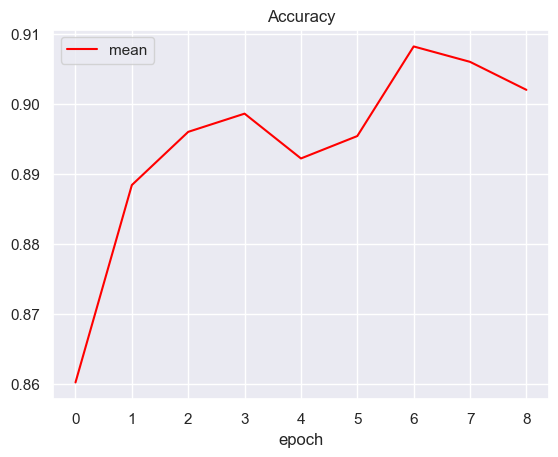

In [36]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Вывод

1. Лучшая accuracy для подхода mean: 90.82

2. До этого я добавлял 5 слоев в RNN и там качество тоже не выросло. Здесь я подумал раз BiRNN дает результат, то и качество будет лучше если добавить слоев. Но в итоге наоборот просело

# Отчет

## Что было сделано

В данной работе были проделаны эксперименты по улучшению качества RNN для задачи классификаци на 4 класса.

Были попытки обучить следущие модели:
    1. Запущен бейзлайн RNN, модель с семинара. Лучшая accuracy для подхода mean: 90.62

    2. Попытка увеличить количество слоев RNN До 5 штук. Лучшая accuracy для подхода mean: 90.00

    3. Попытка конкатенировать аггрегированные hidden states + final hidden state. Лучшая accuracy для подхода mean: 90.32

    4. GRU. Лучшая accuracy для подхода mean: 91.32

    5. Для семинарской модели перебрал параметр counter_threshold, который отвечает за количество слов в словаре. Лучшая accuracy для подхода mean: 91.20 для counter_threshold = 15

    6. BiRNN + counter_threshold = 15. Лучшая accuracy для подхода mean: 91.42
    
    7. BiRNN + 3 слоя + counter_threshold = 15. Лучшая accuracy для подхода mean: 90.82

Лучшее качество показала модель BiRNN + counter_threshold = 15. Лучшая accuracy для подхода mean: 91.42. Следом идет GRU, accuracy для подхода mean: 91.32

Остальные попытки улучшить качество особо не привели к успеху.

## Что еще можно было сделать?

К сожалению не успеваю сделать все эксперименты, тк закончилось время ГПУ в Колабе, пришлось локально обучать последние эксперименты.

Так как GRU дал сразу хороший результат, я бы к нему добавил другой словарь с counter_threshold = 15, а потом еще сделал бы его BiGRU.

В самом конце можно было бы поиграть с шагом обучения, параметрами оптимизатора, количеством эпох, чтобы еще лучше сделать качество.